<a href="https://colab.research.google.com/github/fanny/information-retrieval/blob/master/lab2/text_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Processamento dos texto das notícias

Começamos importando os dados e as dependências. Os dados se encontram no repositório do github, sendo assim fazemos uso de sua url de acesso.  
De dependências, temos:
- [pandas](https://pandas.pydata.org/) e o [numpy](http://www.numpy.org/), para obtenção das estatísticas.
- [ntlk](https://www.nltk.org/) para tokenização e geração de bigramas.   
- [seaborn](https://seaborn.pydata.org/) e matplotlib para geração dos gráficos
- [re](https://docs.python.org/3/library/re.html) para filtrar as palavras válidas

In [61]:
import re

import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt_pyp
%matplotlib inline

data = pd.read_csv('https://raw.githubusercontent.com/fanny/information-retrieval/master/lab2/data/results.csv')
data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,_id,author,date,section,sub_title,text,title,url
0,18,Gazeta do Povo,NaN,educacao,NaN,S o b r e a i n d i c a ç ã o d e q u ...,Populares,https://www.gazetadopovo.com.br/educacao/olavo...
1,6,Agência Estado,NaN,republica,NaN,O l í d e r d o M D B n a C â m a r ...,Populares,https://www.gazetadopovo.com.br/republica/pec-...
2,5,Gazeta do Povo,NaN,curitiba,NaN,D e p o i s d e u m a s e m a n a d e ...,Populares,https://www.gazetadopovo.com.br/curitiba/previ...
3,8,"Raphael Sibila, especial para a Gazeta do Povo",NaN,republica,NaN,“ S e v o c ê n ã o t e m a c a p a ...,Populares,https://www.gazetadopovo.com.br/republica/braz...
4,11,The Daily Signal,NaN,ideias,NaN,P e s s o a s q u e b u s c a m u m a ...,Populares,https://www.gazetadopovo.com.br/ideias/nao-se-...


## Me diga aonde você vai que eu vou varrendo

Agora que temos os dados, precisamos remover as informações que não nos interessam, processo conhecido como *stopping* .
Definimos como não relevantes, as seguintes expressões:
- símbolos
- números  

Para chegar a esse resultado, comecei definindo um regex, que toda vez que encontrasse alguma expressão anterior em cada texto, substituisse por espaço, usando o pacote `re` para manipular o regex  e a função `apply` do pandas, para aplicar essa regra a cada linha do dataframe. Além disso, os valores `na` foram removidos.


In [0]:
def filter_valid_words(text):
  return re.sub(r'(\W+|\d+)', ' ', text.lower())

In [63]:
clean_text = data['text'].dropna()
clean_text = clean_text.apply(filter_valid_words)
clean_text.head(20)

0     s o b r e a i n d i c a ç ã o d e q u e o p r ...
1     o l í d e r d o m d b n a c â m a r a b a l e ...
2     d e p o i s d e u m a s e m a n a d e c a l o ...
3      s e v o c ê n ã o t e m a c a p a c i d a d e...
4     p e s s o a s q u e b u s c a m u m a i d e n ...
7     o s p r e ç o s d o b a i x a r a m t o d a s ...
10    c o n c r e t i z a r a c o m p r a d e u m c ...
11    o l o b b y p e l a a p r o v a ç ã o d a r e ...
12    o e q u a d o r p l a n e j a e x p u l s a r ...
13    a r e c e i t a f e d e r a l i n f o r m o u ...
14    o t é c n i c o d o u m b e r t o l o u z e r ...
15    pessoas que buscam uma identidade transsexual ...
16    depois de uma semana de calor curitiba terá um...
17    as promessas são muitas combater o envelhecime...
18    o líder do mdb na câmara baleia rossi sp proto...
19    o meia atacante maicosuel está com a situação ...
20    concretizar a compra de um carro novo nem semp...
21    o fim do horário de verão mudanças na seco

## J. R. R. Tolkien

Dado que ignoramos as palavras que não são de nosso interesse, podemos *tokenizar* as palavras. E para nos auxiliar,  fazemos uso do método `word_tokenize` da biblioteca `nltk`.

In [64]:
all_formatted_text = clean_text.str.cat(sep=' ') 

word_list = word_tokenize(all_formatted_text)
words = pd.DataFrame(word_list, columns=['word'])
unique_words = words['word'].unique()
words.head(15)

,word
0,s
1,o
2,b
3,r
4,e
5,a
6,i
7,n
8,d
9,i


## Sintonize na frequência

> "Entender a natureza estatística do texto é fundamental para entender modelos de recuperação da informação e algoritmos de rankeamento"

*trecho exraido do livro*

Tendo conhecimento dessa importância, extraímos para cada token gerado, a quantidade de ocorrências(tanto a absoluta, quanto relativa) do mesmo e sumarizamos na tabela abaixo, para tal, usamos o método `value_counts` do `pandas`,  e o `boolean indexing` para filtrar os dados apenas com as características de interesse, nesse caso, palavras que ocorrem mais de mil vezes ou apenas uma vez.

In [0]:
def get_percentage(value):
  return value * 100

In [66]:
frequencies = words['word'].value_counts()
relative_frequencies = words['word'].value_counts(normalize=True)
relative_frequencies = relative_frequencies.apply(get_percentage)

relative_frequencies.head(10)

a      6.460257
e      5.543607
o      5.514854
de     3.161696
s      2.485422
r      2.274949
i      2.164537
que    1.834451
d      1.807998
n      1.768894
Name: word, dtype: float64

In [67]:
statistics = {}
statistics['total_documents'] = len(clean_text)
statistics['total_words_occurences'] = len(words)
statistics['vocabulary_size'] = len(unique_words)
statistics['words_occurring_greater_1000_times'] = len(frequencies[frequencies > 1000])
statistics['words_occurring_once'] = len(frequencies[frequencies == 1])

data_statistics = pd.DataFrame(statistics, index=[0])
data_statistics

,total_documents,total_words_occurences,vocabulary_size,words_occurring_greater_1000_times,words_occurring_once
0,119,86947,9779,15,5151


## TOP 50 HITS


Como já tinhamos os dados estatísticos, para conseguir exibir o ranking, apenas criamos um novo dataframe com os critérios de rankeamento, que são:

- frequência
- posição(ranking)
- porcentagem de ocorrências totais
- *c* = r.Pr

Feito isso, exibimos apenas as 50 primeiros dados

In [68]:
ranking = np.arange(1,len(unique_words)+1)

most_frequent_words = {
    'frequency': frequencies,
    'r': ranking,
    'Pr(%)': relative_frequencies,
    'r.Pr': relative_frequencies * ranking
}

most_frequent_words = pd.DataFrame(most_frequent_words)
most_frequent_words.head(50)

,frequency,r,Pr(%),r.Pr
a,5617,1,6.460257,6.460257
e,4820,2,5.543607,11.087214
o,4795,3,5.514854,16.544562
de,2749,4,3.161696,12.646785
s,2161,5,2.485422,12.427111
r,1978,6,2.274949,13.649695
i,1882,7,2.164537,15.151759
que,1595,8,1.834451,14.675607
d,1572,9,1.807998,16.271982
n,1538,10,1.768894,17.688937


## "I see it, I like it"


Para conseguir visualizar como a frequência influência no ranking, como descreve a *Lei de Zipf*, tanto para os unigramas quanto para os bigramas, no caso do segundo, foi necessário utilizar o método `bigrams` do `nltk`, que gera os pares de palavras, usamos gráficos e como pode ser visto abaixo, quanto maior o ranking menor a frequência.

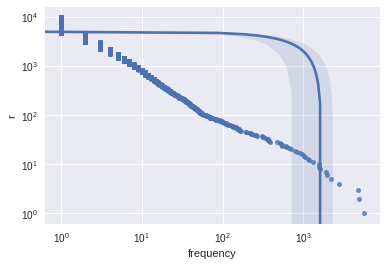

In [69]:
f, ax = plt_pyp.subplots()
ax.set(xscale="log", yscale="log")

sns.regplot(x="frequency", y="r", data=most_frequent_words,ax=ax, marker='.', scatter_kws={"s": 100})

In [70]:

bigrams = list(nltk.bigrams(list(words['word'].values)))
bigrams_frequency = nltk.FreqDist(bigrams)

bigrams = pd.DataFrame({
    'bigram': list(bigrams_frequency.keys()),
    'frequency': list(bigrams_frequency.values()),
})
bigrams['ranking'] = bigrams['frequency'].rank(ascending=True, method='first')
bigrams['ranking'] = bigrams['ranking'].astype(int)
bigrams = bigrams.sort_values(by='ranking')
bigrams.tail()

,bigram,frequency,ranking
125,"(a, s)",434,39892
88,"(r, a)",445,39893
25,"(e, n)",464,39894
22,"(e, s)",552,39895
15,"(d, e)",582,39896


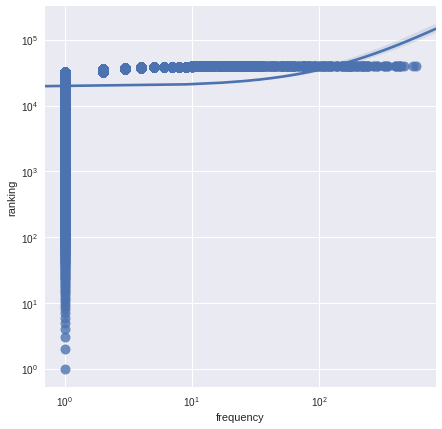

In [71]:
f, ax = plt_pyp.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")

sns.regplot(x="frequency", y="ranking", data=bigrams,ax=ax, scatter_kws={"s": 100})

## Previsões

Uma palavra pode ocorrer n vezes em um texto, se tivermos interessados em calcular a proporção de palavras com essa frequência, a *Lei de Zipf* afirma que ela será dada por essa fórmula:   
`1/n*(n+1)`  

Para obter os valores de frequencias, agrupamos(`groupby`) e aplicamos essa fórmula para cada um deles, desse modo, obtemos a proporção estimada.
Para a proporção real, usamos a quantidade de elementos de cada frequência e dividimos pelo total(tam do vocabulário).


In [0]:
def get_current_proportion(frequency):
  return frequency / statistics['vocabulary_size']

def get_predicted_proportions(occurrences):
  predicted_proportions = [] 
  for n in occurrences:
    predicted_proportion = 1 / (n * (n + 1))
    predicted_proportions.append(predicted_proportion)
  
  return predicted_proportions

In [0]:
grouped_words_by_frequency = most_frequent_words.groupby('frequency')['r']
current_number_of_words = grouped_words_by_frequency.count()
number_of_occurrences = grouped_words_by_frequency.groups.keys()
current_proportion = current_number_of_words.apply(get_current_proportion)
predicted_proportions = get_predicted_proportions(number_of_occurrences)

In [74]:
proportions_of_words = {
    'predicted_proportions': predicted_proportions,
    'current_proportion': current_proportion,
    'current_number_of_words': current_number_of_words
}
proportions_of_words = pd.DataFrame(proportions_of_words)
proportions_of_words.index.names = ['number_of_occurrences']
proportions_of_words.head(10)

,predicted_proportions,current_proportion,current_number_of_words
number_of_occurrences,,,
1,0.500000,0.526741,5151
2,0.166667,0.167809,1641
3,0.083333,0.078945,772
4,0.050000,0.045301,443
5,0.033333,0.033439,327
6,0.023810,0.019225,188
7,0.017857,0.018816,184
8,0.013889,0.012987,127
9,0.011111,0.010840,106
